In [1]:
# For section 1
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import matplotlib
import contextily as ctx
import time
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely import geometry
%matplotlib inline

In [2]:
# For section 2
import numpy as np
import rasterio
from rasterio import plot
from rasterio.mask import mask
from statsmodels.tsa.seasonal import seasonal_decompose
import os

## Section 1

In [3]:
# Map the project areas

In [4]:
# Defining the plotting function for geographic coordinates
def plot_area_geographic(gdframe, grat, country, c=0):
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    gdframe.plot(ax=ax, color="#A93226", edgecolor='black', linewidth=1)    
    minx, maxx = gdframe.bounds.minx[0], gdframe.bounds.maxx[0]    
    miny, maxy = gdframe.bounds.miny[0], gdframe.bounds.maxy[0]
        
    extent = (minx -15, maxx + 15, miny - 15, maxy + 15)    
    ax.axis(extent)

    ctx.add_basemap(ax, zoom='auto', crs=gdframe.crs, alpha=0.7, source=ctx.providers.OpenStreetMap.Mapnik)

    # Add north arrow and scalebar
    x, y, arrow_length = 0.02, 0.15, 0.1

    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(arrowstyle='->'),
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes)

    fontprops = matplotlib.font_manager.FontProperties(size=10, stretch='ultra-expanded')

    # Zoom on the area
    axin = ax.inset_axes([0.5, 0.1, 0.5, 0.5])
    
    axin.axis((minx - 0.05, maxx + 0.05, miny - 0.12, maxy + 0.05))
    
    # Since 1° longitude = ca. 111.321 km at the equator and 0 km at the poles, sizebar length is:
    bar_to_km = round((maxx - minx) * 111.321 * (1 - (abs(miny + maxy)/2)/90))

    scalebar = AnchoredSizeBar(axin.transData,
                               maxx - minx, f'{bar_to_km} km', 'lower center',
                               pad=5,
                               frameon=False,
                               size_vertical=0.00005,
                               sep=1.5,
                               label_top=True,
                               fontproperties=fontprops)
        
    ctx.add_basemap(axin, zoom='auto', crs=gdframe.crs)

    axin.add_artist(scalebar)
    
    # For Brasil
    if c == 0:
        axin.set_title('Brazil - Agrocortex REDD project')
    # For Cambodia
    else:
        axin.set_title('Cambodia - Tumring REDD+ project')

    # Add the graticule and national boundaries
    grat.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.3)
    country.plot(ax=ax, facecolor='none',edgecolor="black", linewidth=1.5)

    gdframe.plot(ax=axin, color="#A93226", edgecolor='black', linewidth=0.3)    
    ax.indicate_inset_zoom(axin)
        
    if c == 0:
        plt.savefig('out/imgs/Brazil - Agrocortex REDD project.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
    else:
        plt.savefig('out/imgs/Cambodia - Tumring REDD+ project.png', bbox_inches='tight', pad_inches=0.2, dpi=300)

In [5]:
# Defining the plotting function for projected coordinates
def plot_area_projected(gdframe, country, c=0):
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    gdframe.plot(ax=ax, color="#A93226", edgecolor='black', linewidth=0.3)    
    minx, maxx = gdframe.bounds.minx[0], gdframe.bounds.maxx[0]    
    miny, maxy = gdframe.bounds.miny[0], gdframe.bounds.maxy[0]
        
    extent = (minx - 1700000, maxx + 1700000, miny - 1700000, maxy + 1700000)  

    ax.axis(extent)
    
    ctx.add_basemap(ax, zoom='auto', crs=gdframe.crs, alpha=0.7, source=ctx.providers.OpenStreetMap.Mapnik)

    # Add north arrow and scalebar
    x, y, arrow_length = 0.02, 0.15, 0.1

    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(arrowstyle='->'),
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes)

    fontprops = matplotlib.font_manager.FontProperties(size=10, stretch='ultra-expanded')

    # Zoom on the area
    axin = ax.inset_axes([0.5, 0.1, 0.5, 0.5])
    
    axin.axis((minx - 9000, maxx + 9000, miny - 12000, maxy + 9000))
    
    scalebar = AnchoredSizeBar(axin.transData,
                               maxx - minx, f'{round((maxx - minx)/1000)} km', 'lower center',
                               pad=5,
                               frameon=False,
                               size_vertical=0.00005,
                               sep=1.5,
                               label_top=True,
                               fontproperties=fontprops)
        
    ctx.add_basemap(axin, zoom='auto', crs=gdframe.crs)

    axin.add_artist(scalebar)
    axin.set_axis_off()

    # For Brasil
    if c == 0:
        axin.set_title('Brazil - Agrocortex REDD project')
    # For Cambodia
    else:
        axin.set_title('Cambodia - Tumring REDD+ project')

    # Add the national boundaries
    country.plot(ax=ax, facecolor='none',edgecolor="black", linewidth=1.5)

    gdframe.plot(ax=axin, color="#A93226", edgecolor='black', linewidth=0.3)    
    ax.indicate_inset_zoom(axin)

In [6]:
# Import the shapefile of the graticule
graticule = gpd.read_file('coords/graticule/graticule.shp')
graticule.crs 

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 1.1 - Agrocortex REDD project

In [7]:
# Importing the KML driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'r'

In [8]:
agrocortex_fromKML = gpd.read_file('coords/agrocortex.kml',driver='KML')

In [9]:
bra_contour = gpd.read_file('coords/brasil_coords/brasil.shp')

In [10]:
# Check that coordinate reference systems match
graticule.crs == bra_contour.crs

True

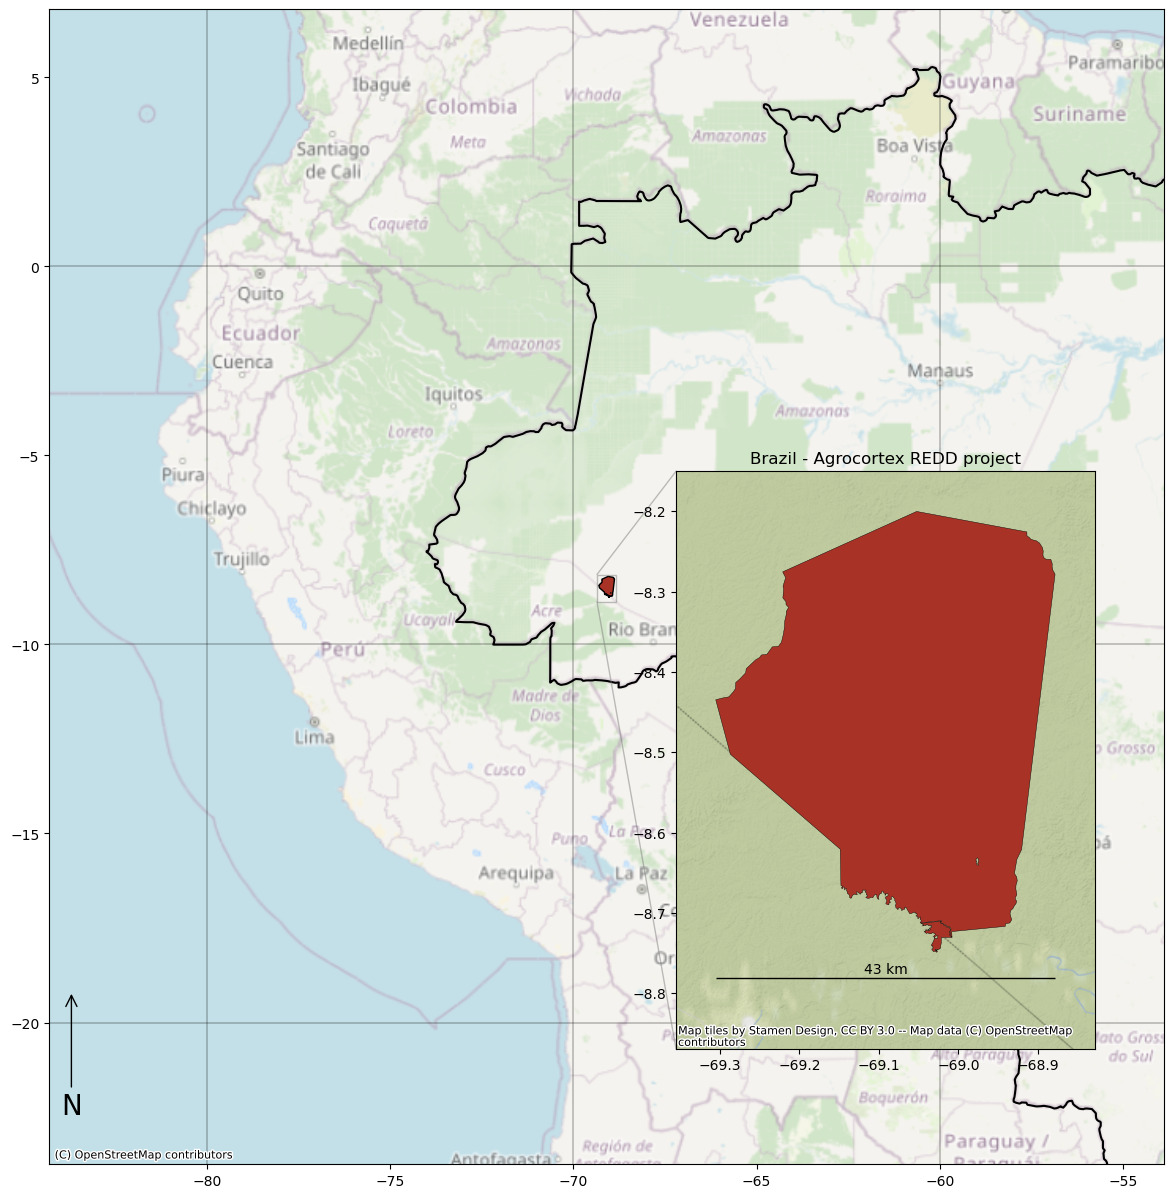

In [11]:
plot_area_geographic(agrocortex_fromKML, graticule, bra_contour)

In [12]:
# Compare areas

In [13]:
agrocortex_area_KML = agrocortex_fromKML.to_crs('epsg:32719').area/10e3
agrocortex_area_KML

0    186313.606484
dtype: float64

### 1.2 - Tumring REDD+ project

In [14]:
tumring_fromKML = gpd.read_file('coords/tumring.kml',driver='KML')
tumring_fromKML.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
camb_contour = gpd.read_file('coords/cambodia_coords/cambodia.shp')

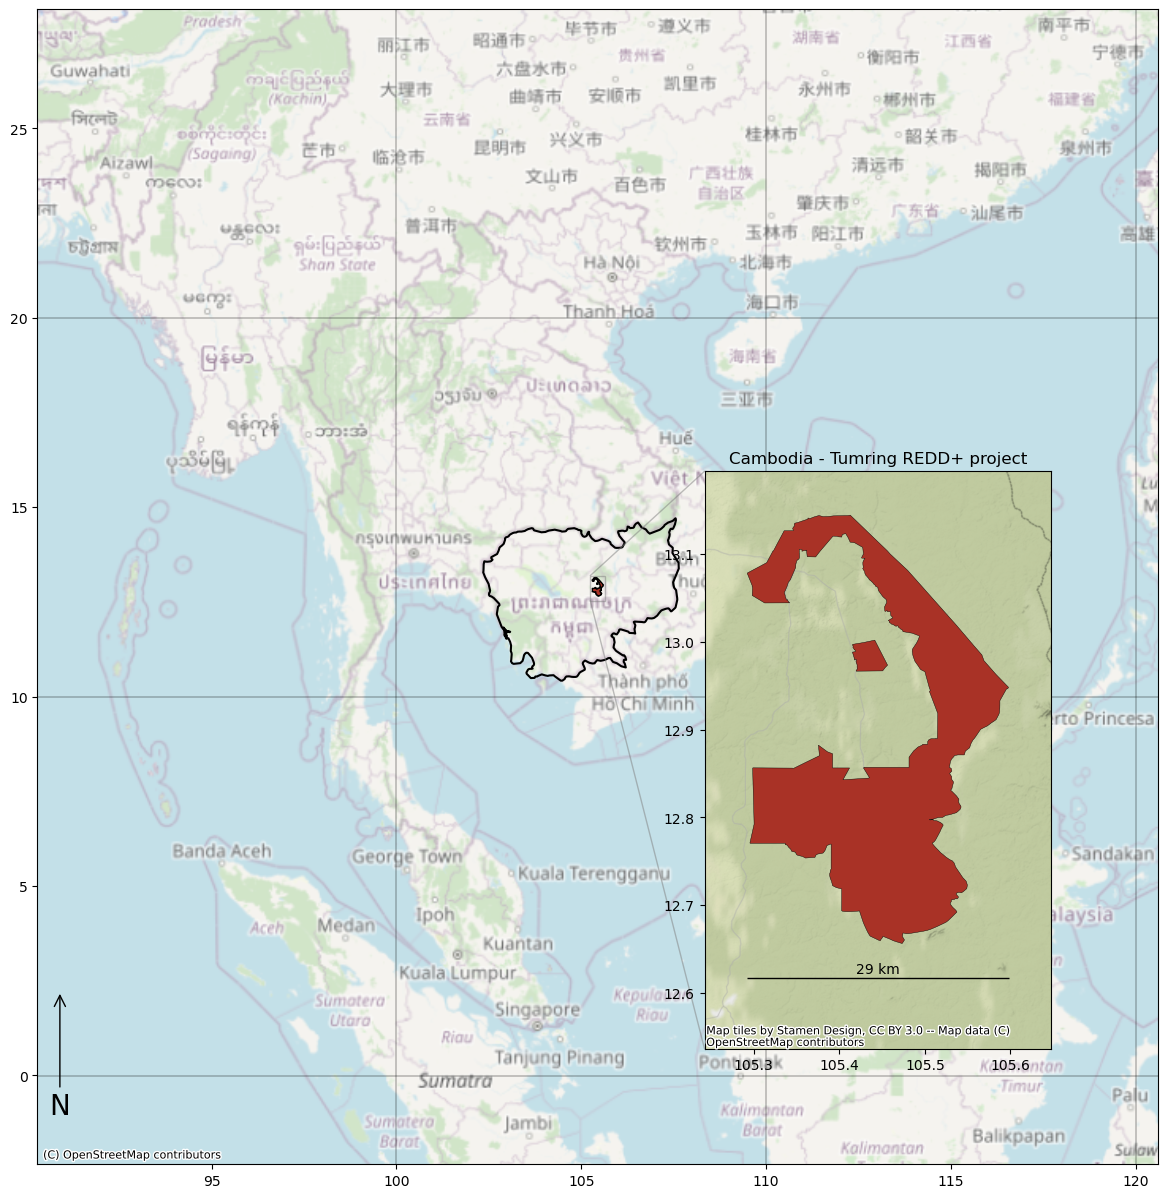

In [16]:
plot_area_geographic(tumring_fromKML, graticule, camb_contour, 1)

In [17]:
 # Turming project area
tumring_fromKML.to_crs('epsg:32648').area/10e3

0    67791.17118
dtype: float64

In [18]:
# Saving the shapefiles for a later use (non-projected)
agrocortex_fromKML.to_file('out/project areas shp/agrocortex.shp', driver='ESRI Shapefile', crs=agrocortex_fromKML.crs)
tumring_fromKML.to_file('out/project areas shp/tumring.shp', driver='ESRI Shapefile', crs=tumring_fromKML.crs)

C:\Users\gab\miniconda3\envs\spatiotemp\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\gab\AppData\Local\Temp\ipykernel_3100\256171960.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  agrocortex_fromKML.to_file('out/project areas shp/agrocortex.shp', driver='ESRI Shapefile', crs=agrocortex_fromKML.crs)
C:\Users\gab\miniconda3\envs\spatiotemp\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\gab\AppData\Local\Temp\ipykernel_3100\256171960.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tumring_fromKML.to_file('out/project areas

In [19]:
# Saving the shapefiles for a later use (projected)
agrocortex_fromKML.to_crs('epsg:32719').to_file('out/project areas shp/agrocortex_projected.shp', driver='ESRI Shapefile', crs=agrocortex_fromKML.crs)
tumring_fromKML.to_crs('epsg:32648').to_file('out/project areas shp/tumring_projected.shp', driver='ESRI Shapefile', crs=tumring_fromKML.crs)

C:\Users\gab\miniconda3\envs\spatiotemp\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\gab\AppData\Local\Temp\ipykernel_3100\1931802697.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  agrocortex_fromKML.to_crs('epsg:32719').to_file('out/project areas shp/agrocortex_projected.shp', driver='ESRI Shapefile', crs=agrocortex_fromKML.crs)
C:\Users\gab\miniconda3\envs\spatiotemp\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\gab\AppData\Local\Temp\ipykernel_3100\1931802697.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tumring_f

In [20]:
agrocortex_path = "out/project areas shp/agrocortex.shp"
tumring_path = "out/project areas shp/tumring.shp"

In [21]:
agrocortex_path_projected = "out/project areas shp/agrocortex_projected.shp"
tumring_path_projected = "out/project areas shp/tumring_projected.shp"

## Section 2

In [22]:
# Time-series of forest loss

In [23]:
# Define the clipping area
def boundaries(shapefile_path):
    
    with fiona.open(shapefile_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    def is_mappable(x):
        try:
            float(x[0])
            return True
        except:
            return False

    def c_3d_to_2d(coords):
        _coords = []
        for coord in coords:
            if is_mappable(coord):
                _coords.append((coord[0], coord[1]))
            else:
                _coords.append(c_3d_to_2d(coord))
        return _coords

    return [{"type": g["type"], "coordinates": c_3d_to_2d(g["coordinates"]),} for g in shapes]

In [24]:
def clip_area(shapes, directory, layers):
    for file in layers:
        try:
            with rasterio.open(f'{directory}/{file}') as src:

                out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=-1, filled=True)
                out_meta = src.meta

                out_meta.update({"driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform})

                with rasterio.open(f"out/clipped layers/{file[:-4]}_clipped.tif", "w", **out_meta) as dest:
                    dest.write(out_image)
        except:
            pass

In [25]:
def extract_values(layer_p):
    
    scale_factor = .84
        
    with rasterio.open(f'out/clipped layers/{layer_p[:-4]}_clipped.tif') as src:
        img = src.read(1)
    
    unique, count = np.unique(img, return_counts = True)
    shape_counts = {unique[i]: count[i] for i in range(len(unique))}
        
    # Compute the area with 30x30m pixels, (skip 255 since it corresponds to outside of boundaries)
    area_tot_ha = sum(value for key, value in shape_counts.items() if key != 255) * 30**2 / 10e3
    area_rem_ha = area_tot_ha.copy()

    area_tot_ha *= scale_factor
    area_rem_ha *= scale_factor
    
    values_lst = []
    for pixel_value, count in shape_counts.items():

        if not pixel_value == 255:
        
            # codes 0-21 correspond to 2000-2021 loss
            year = pixel_value + 2000

            area_ha = count * 30**2 / 10e3 * scale_factor

            if pixel_value == 0:
                values_lst.append((0, 100))
            else:
                values_lst.append((round(area_ha, 3), round(((area_rem_ha - area_ha) / area_tot_ha) * 100, 3)))

                area_rem_ha -= area_ha
                
    return pd.DataFrame(values_lst, index =list(np.arange(2000, 2022)),
                        columns= ['loss to 2000 (ha)', 'tot left (%)'])

In [26]:
def plot_forest_loss(data, c=0):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.grid(axis="x")
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.bar(list(data.index), data['loss to 2000 (ha)'], color='green')
    loss_max, loss_min = int(data['loss to 2000 (ha)'].max()), int(data['loss to 2000 (ha)'].min())
    ax.set_xlabel('Year')
    ax.set_ylabel('lost hectares', color='green')
    ax.set_yticks(range(loss_min +1, loss_max +2, int((loss_max - loss_min) /10)))
    ax.set_yticklabels(range(loss_min +1, loss_max +2, int((loss_max - loss_min) /10)))
    ax.set_xticks(range(2000, 2022))
    ax.set_xticklabels(range(2000, 2022))
    ax.tick_params(axis='y', labelcolor='green')
    trans = ax.get_xaxis_transform()
    if c == 0:
        ax.set_title('Agrocortex REDD project\nForest loss per year (base year: 2000)', size=18)
        ax.axvline(2014, c='red', linestyle='--', linewidth=1.5)
        plt.text(2014, .75, 'project start', fontsize=12, rotation=90, transform=trans)

    else:
        ax.set_title('Tumring REDD+ project\nForest loss per year (base year: 2000)', size=18)
        ax.axvline(2015, c='red', linestyle='--', linewidth=1.5)
        plt.text(2015, .75, 'project start', fontsize=12, rotation=90, transform=trans)

        
    ax2 = ax.twinx()
    ax2.plot(list(data.index), data['tot left (%)'], color ='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel('remaining hectares (%)', color='black')

    fig.tight_layout()
    
    if c == 0:
        plt.savefig('out/imgs/Brazil - Agrocortex REDD project_timeseries.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
    else:
        plt.savefig('out/imgs/Cambodia - Tumring REDD+ project_timeseries.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
    
    def plot_timeseries():

        additive_decompose = seasonal_decompose(data['loss to 2000 (ha)'], model='additive', period=1)
        additive_decompose.plot().suptitle('\n\nAdditive decompose')

        fig.tight_layout()
    
    def differencing():
        
        fig, ax = plt.subplots(figsize=(15,10))
        ax.grid(axis="x")
        ax.grid(axis="y")
        ax.set_axisbelow(True)
        ax.set_xlabel('Year')
        ax.set_ylabel('lost hectares')
        data['loss to 2000 (ha) diff'] = data['loss to 2000 (ha)'] - data['loss to 2000 (ha)'].shift(1)
        diff_max, diff_min = int(data['loss to 2000 (ha) diff'].max()), int(data['loss to 2000 (ha) diff'].min())
        ax.set_yticks(range(diff_min, diff_max +2, int((diff_max - diff_min) /10)))
        ax.set_yticklabels(range(diff_min, diff_max +2, int((diff_max - diff_min) /10)))
        ax.set_xticks(range(2001, 2022))
        ax.set_xticklabels(range(2001, 2022))
        trans = ax.get_xaxis_transform()
        if c == 0:
            ax.set_title('Agrocortex REDD project\nLost hectares compared to previous year (annual differencing)', size=18)
            ax.axvline(2014, c='red', linestyle='--', linewidth=1.5)
            plt.text(2014, .75, 'project start', fontsize=12, rotation=90, transform=trans)
        else:
            ax.set_title('Tumring REDD+ project\nLost hectares compared to previous year (annual differencing)', size=18)
            ax.axvline(2015, c='red', linestyle='--', linewidth=1.5)
            plt.text(2015, .75, 'project start', fontsize=12, rotation=90, transform=trans)
        
        ax.plot(data['loss to 2000 (ha) diff'], color ='green')
                
        if c == 0:
            plt.savefig('out/imgs/Brazil - Agrocortex REDD project_ann_diff.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
        else:
            plt.savefig('out/imgs/Cambodia - Tumring REDD+ project_ann_fiff.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
        
    plot_timeseries()
    differencing()

### 2.1 - Agrocortex REDD project

In [27]:
# Checking the layers for the Agrocortex project
agro_dir = 'layers/hansen/bra'
agro_layers = os.listdir(agro_dir)
agro_layers

['Hansen_GFC-2021-v1.9_lossyear_00N_070W.tif']

In [28]:
agro_shapes = boundaries(agrocortex_path)

In [29]:
clip_area(agro_shapes, agro_dir, agro_layers)

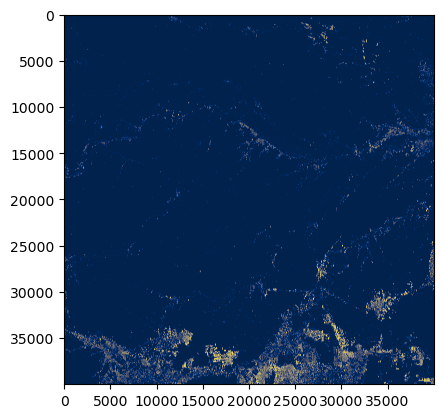

In [30]:
# Visualise the unclipped layer
src = rasterio.open('layers/hansen/bra/Hansen_GFC-2021-v1.9_lossyear_00N_070W.tif')
array = src.read(1)
plt.imshow(array, cmap='cividis')

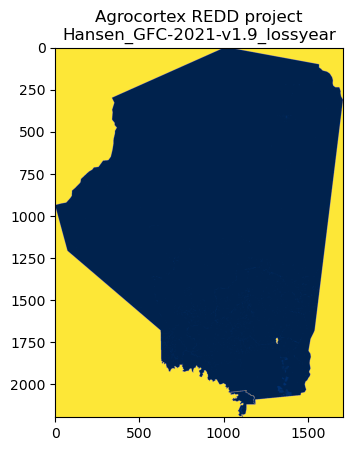

In [31]:
# Check the shape of the clipped layer
agro_layers_dict = {}
for layer in agro_layers:
    try:
        src = rasterio.open(f'out/clipped layers/{layer[:-4]}_clipped.tif')
        bands = src.read()
        agro_layers_dict[f'{layer[:-4]}_clipped'] = bands.shape
        array = src.read(1)
        plt.imshow(array, cmap='cividis')
        plt.title(f'Agrocortex REDD project\n{layer[:-13]}')
        
    except:
        pass

In [32]:
agro_layers_dict

{'Hansen_GFC-2021-v1.9_lossyear_00N_070W_clipped': (1, 2196, 1709)}

In [33]:
agro_forest_loss = extract_values(agro_layers[0])
agro_forest_loss

loss to 2000 (ha)  tot left (%)
2000              0.000       100.000
2001              8.467        99.995
2002             17.690        99.986
2003              7.560        99.982
2004             17.917        99.972
2005             26.233        99.958
2006             10.282        99.952
2007             15.422        99.944
2008              6.275        99.941
2009             12.398        99.934
2010             35.834        99.915
2011             17.766        99.905
2012             47.401        99.879
2013             11.718        99.873
2014            108.864        99.814
2015            207.824        99.702
2016            224.683        99.581
2017            188.244        99.479
2018            209.866        99.366
2019            103.496        99.310
2020             74.920        99.269
2021            103.194        99.214

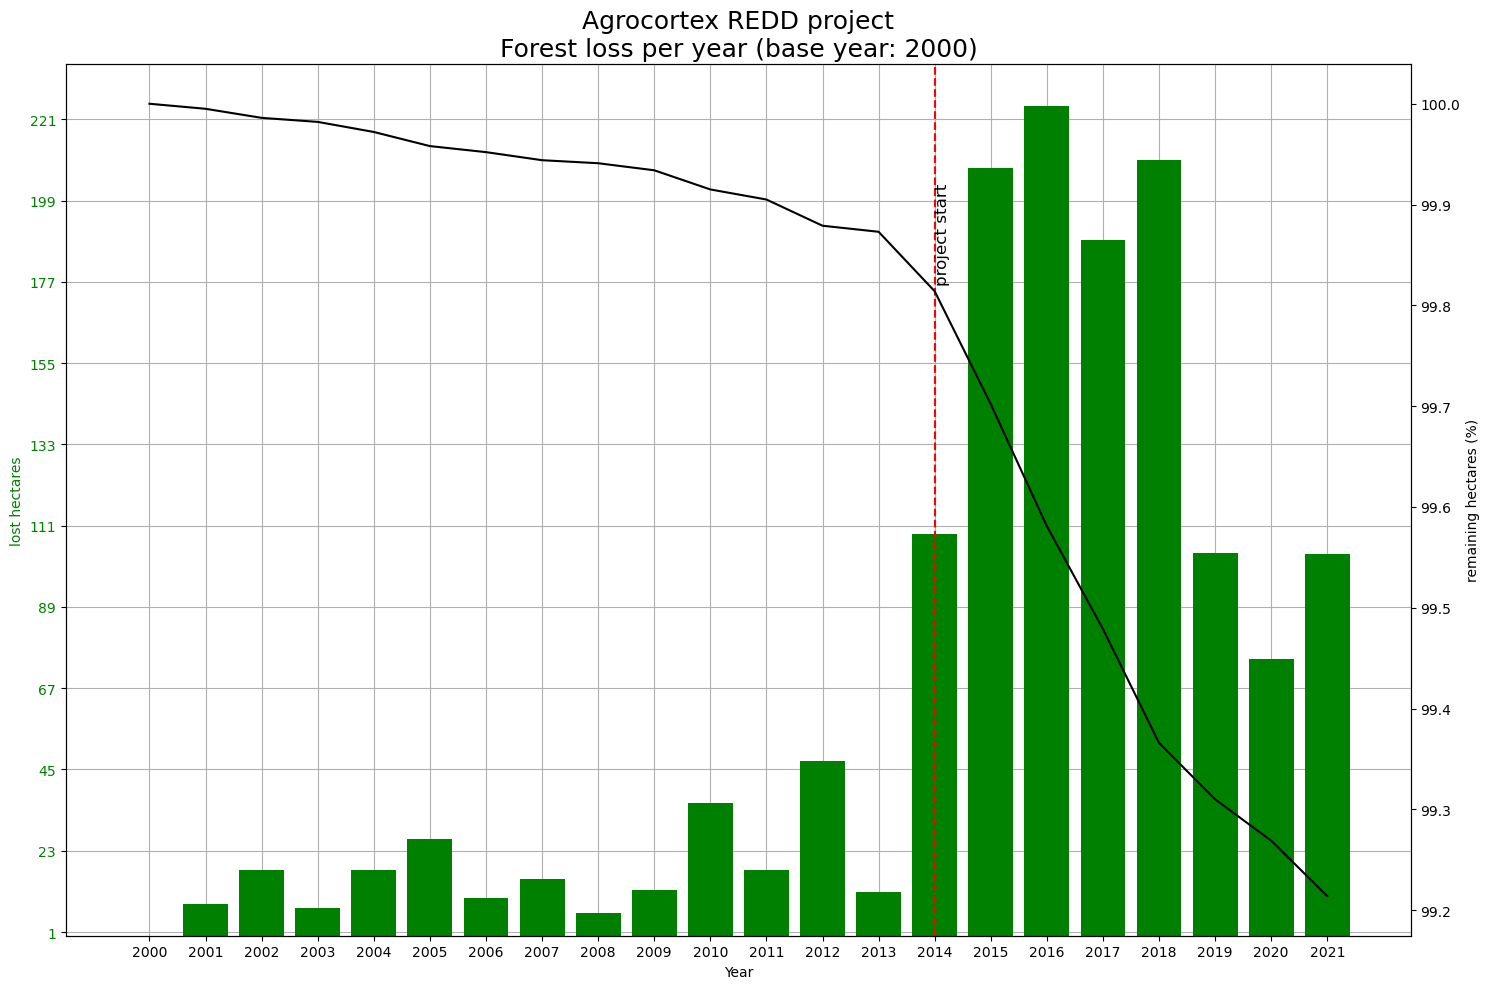

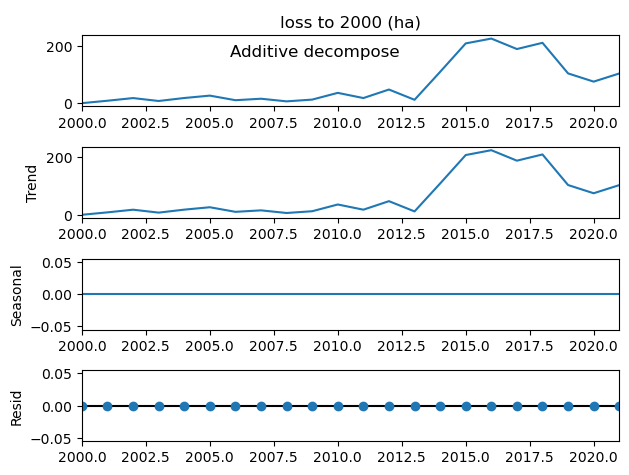

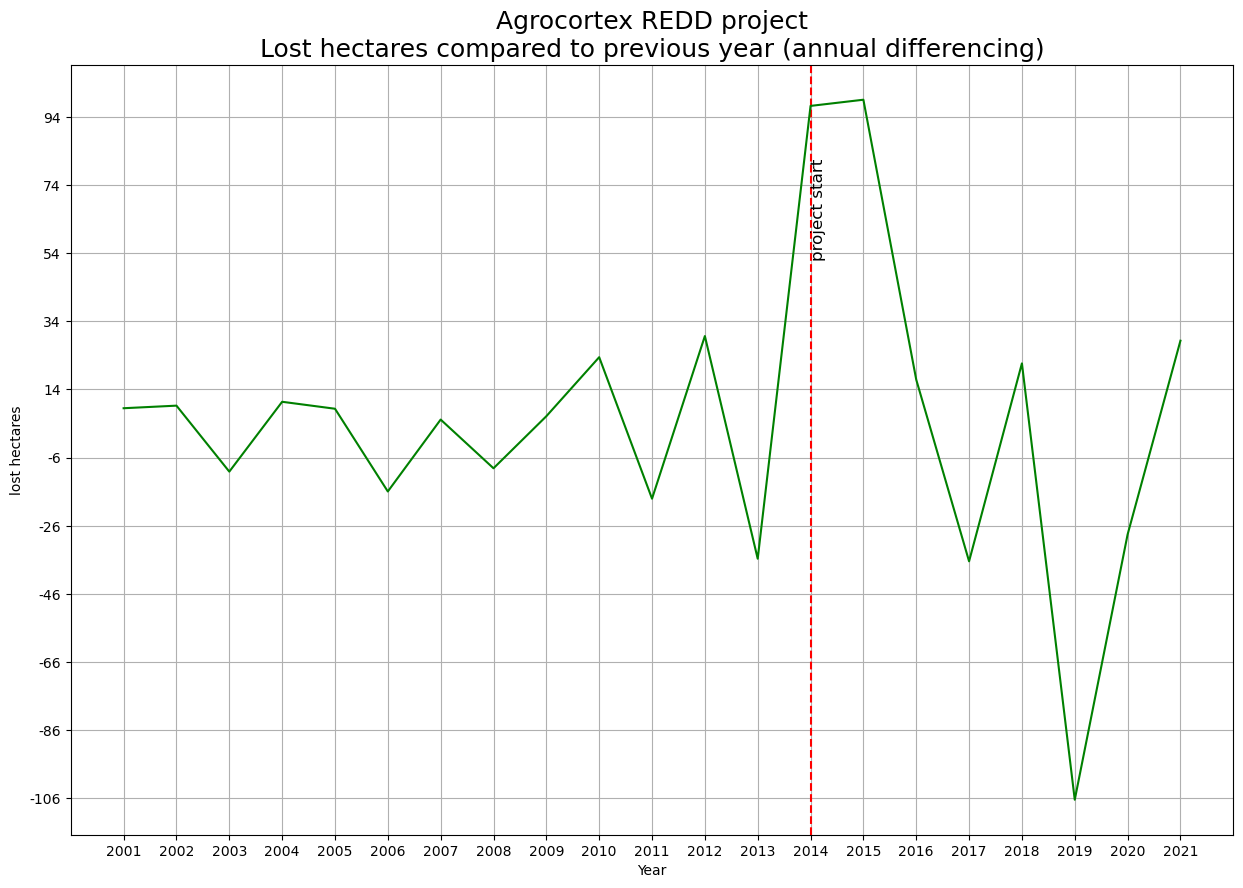

In [34]:
plot_forest_loss(agro_forest_loss)

### 2.2 - Tumring REDD+ project

In [35]:
# Checking the layers for the Agrocortex project
camb_dir = 'layers/hansen/camb'
camb_layers = os.listdir(camb_dir)
camb_layers

['Hansen_GFC-2021-v1.9_lossyear_20N_100E.tif']

In [36]:
tumring_shapes = boundaries(tumring_path)

In [37]:
clip_area(tumring_shapes, camb_dir, camb_layers)

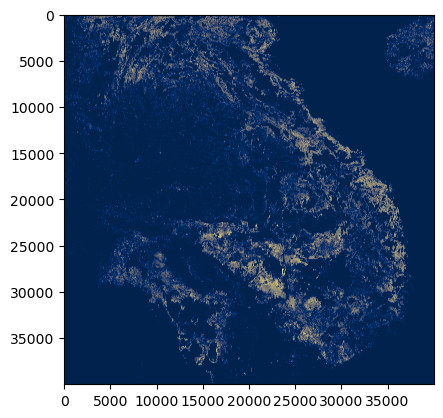

In [38]:
# Visualise the unclipped layer
src = rasterio.open('layers/hansen/camb/Hansen_GFC-2021-v1.9_lossyear_20N_100E.tif')
array = src.read(1)
plt.imshow(array, cmap='cividis')

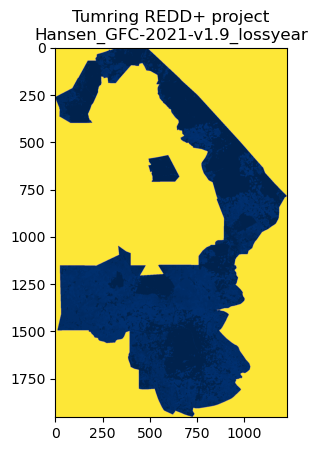

In [39]:
# Check the shape of the clipped layer
camb_layers_dict = {}
for layer in camb_layers:
    try:
        src = rasterio.open(f'out/clipped layers/{layer[:-4]}_clipped.tif')
        bands = src.read()
        camb_layers_dict[f'{layer[:-4]}_clipped'] = bands.shape
        array = src.read(1)
        plt.imshow(array, cmap='cividis')
        plt.title(f'Tumring REDD+ project\n{layer[:-13]}')
    except:
        pass

In [40]:
camb_layers_dict

{'Hansen_GFC-2021-v1.9_lossyear_20N_100E_clipped': (1, 1954, 1223)}

In [41]:
camb_forest_loss = extract_values(camb_layers[0])
camb_forest_loss

loss to 2000 (ha)  tot left (%)
2000              0.000       100.000
2001            113.627        99.834
2002             84.974        99.709
2003            202.608        99.413
2004            212.209        99.102
2005            261.500        98.720
2006            270.875        98.323
2007            252.202        97.954
2008            343.224        97.452
2009            449.896        96.793
2010            509.015        96.049
2011           1118.804        94.411
2012           1311.509        92.492
2013           2478.924        88.864
2014           3051.594        84.398
2015           3653.975        79.051
2016           5889.316        70.432
2017           3595.460        65.170
2018           3344.846        60.275
2019           3434.962        55.248
2020           3267.734        50.466
2021           5020.218        43.120

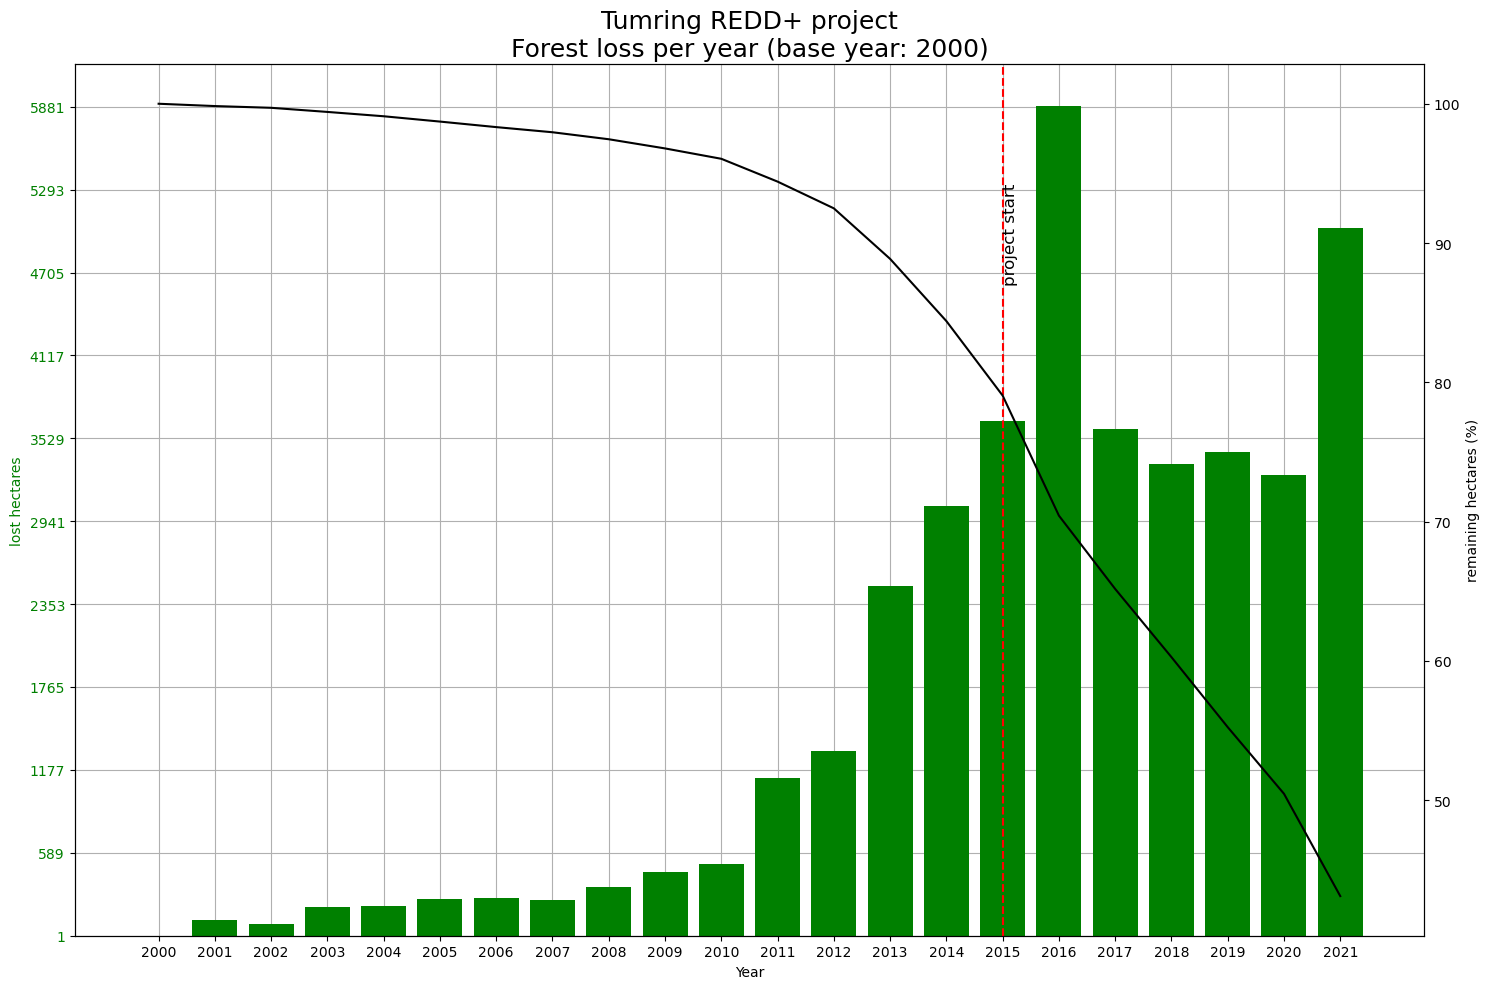

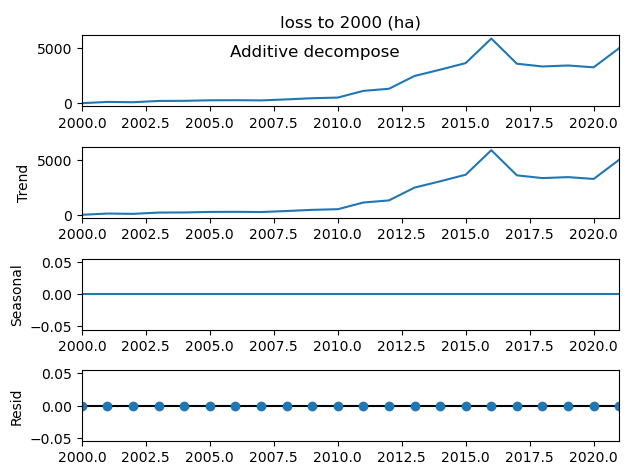

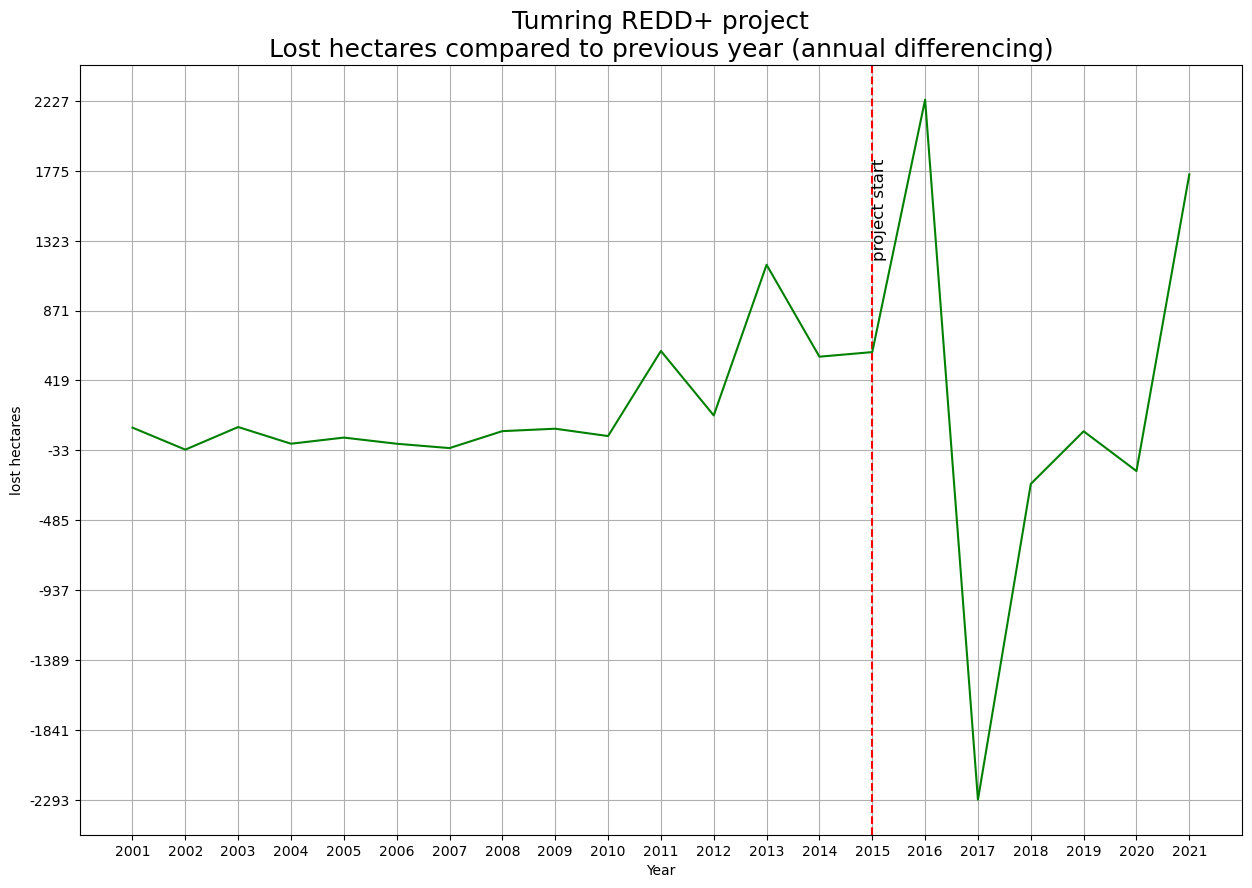

In [42]:
plot_forest_loss(camb_forest_loss, 1)

In [43]:
# Project area ratio
project_area_ratio = agrocortex_fromKML.to_crs('epsg:32719').area / tumring_fromKML.to_crs('epsg:32648').area 

In [44]:
# Average rate of deforestation over the project period
int(camb_forest_loss['loss to 2000 (ha)'].iloc[-7:].mean() / agro_forest_loss['loss to 2000 (ha)'].iloc[-8:].mean() * project_area_ratio)

72

## Section 3

In [45]:
# Compute vegetation indices (2016 and 2021)

In [46]:
def read_bands(sent2_layers):
    
    sent2_layers = iter(sent2_layers)
    
    bands_dict = {}
    # Imagery refers to 2016 and 2021 for both projects.
    for year in range(2016, 2022, 5):
        bands_dict[f'{year}_blue'] = rasterio.open(f'out/clipped layers/{next(sent2_layers)[:-4]}_clipped.tif')
        bands_dict[f'{year}_red'] = rasterio.open(f'out/clipped layers/{next(sent2_layers)[:-4]}_clipped.tif')
        bands_dict[f'{year}_nir'] = rasterio.open(f'out/clipped layers/{next(sent2_layers)[:-4]}_clipped.tif')

    return bands_dict

In [47]:
def compute_indices(bands_dict, c=0):  
    
    for_indices = bands_dict.copy()
    
    
    # Bands are converted to float32 types to allow the division when computing indices
    for k in for_indices:
        for_indices[k] = for_indices[k].read(1).astype('float32')
    
    indices_dict = {}
    
    def ndvi():
        
        indices_dict['ndvi_2016'] = (for_indices['2016_nir'] - for_indices['2016_red']) / (for_indices['2016_nir'] + for_indices['2016_red'])
                    
        indices_dict['ndvi_2021'] = (for_indices['2021_nir'] - for_indices['2021_red']) / (for_indices['2021_nir'] + for_indices['2021_red'])
                
        indices_dict['ndvi_diff'] = indices_dict['ndvi_2016'] - indices_dict['ndvi_2021']
        
    def evi():
    
        # EVI = 2.5 * ((NIR - RED) / (NIR + C1 * RED - C2 * BLUE + L))    
        
        # Typical values
        c_one, c_two, l = 6, 7.5, 1
        
        # Divide by 10000 as per Sebrinel 2A documentation
        for k in for_indices:
            for_indices[k] /= np.array(1e4) 
    
        
        indices_dict['evi_2016'] = 2.5 *((for_indices['2016_nir'] - for_indices['2016_red']) 
                         / (for_indices['2016_nir'] + c_one * for_indices['2016_red'] - 
                            c_two * for_indices['2016_blue'] + l))

        indices_dict['evi_2021'] = 2.5 *((for_indices['2021_nir'] - for_indices['2021_red']) 
                         / (for_indices['2021_nir'] + c_one * for_indices['2021_red'] - 
                            c_two * for_indices['2021_blue'] + l))
        
        indices_dict['evi_diff'] = indices_dict['evi_2016'] - indices_dict['evi_2021']
        
        
    def save_index():
        # Save the index for 2016
        with rasterio.open(f'out/imgs/{project}_{index}_2016.tiff', 'w', driver='Gtiff',
                          width=bands_dict['2016_nir'].width, height=bands_dict['2016_nir'].height,
                          count=1, crs=bands_dict['2016_nir'].crs,
                          transform=bands_dict['2016_nir'].transform,
                          dtype='float64') as file:        

            file.write(indices_dict[f'{index}_2016'], 1)

        # Save the index for 2021
        with rasterio.open(f'out/imgs/{project}_{index}_2021.tiff', 'w', driver='Gtiff',
                          width=bands_dict['2021_nir'].width, height=bands_dict['2021_nir'].height,
                          count=1, crs=bands_dict['2021_nir'].crs,
                          transform=bands_dict['2021_nir'].transform,
                          dtype='float64') as file:

            file.write(indices_dict[f'{index}_2021'], 1)
            
        # Save the index for differences
        with rasterio.open(f'out/imgs/{project}_{index}_5_year_diff.tiff', 'w', driver='Gtiff',
                          width=bands_dict['2021_nir'].width, height=bands_dict['2021_nir'].height,
                          count=1, crs=bands_dict['2021_nir'].crs,
                          transform=bands_dict['2021_nir'].transform,
                          dtype='float64') as file:

            file.write(indices_dict[f'{index}_diff'], 1)

    def plot_index():        
        with rasterio.open(f'out/imgs/{project}_{index}_2016.tiff') as file_2016:
            with rasterio.open(f'out/imgs/{project}_{index}_2021.tiff') as file_2021:

                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
                plot.show(file_2016, ax=ax1, cmap='BrBG', title=f'{project} - {index.upper()} 2016')
                plot.show(file_2021, ax=ax2, cmap='BrBG', title=f'{project} - {index.upper()} 2021')
                plot.show(file_2016.read(1) - file_2021.read(1), ax=ax3, cmap='RdBu_r', title=f'{project} - {index.upper()} - 5 year difference')    

                fig.tight_layout()

    
    if c == 0:
        project = 'agrocortex'
    else:
        project = 'tumring'
    
    ndvi()
    index = 'ndvi'
    save_index()
    plot_index()
    
    evi()
    index = 'evi'
    save_index()
    plot_index()

### 3.1 - Agrocortex REDD project

In [48]:
agro_sent2_dir = 'layers/sent 2/bra'
agro_sent2_layers = os.listdir(agro_sent2_dir)
agro_sent2_layers

['T19LDL_20160729T145732_B02.jp2',
 'T19LDL_20160729T145732_B04.jp2',
 'T19LDL_20160729T145732_B08.jp2',
 'T19LDL_20210703T145731_B02.jp2',
 'T19LDL_20210703T145731_B04.jp2',
 'T19LDL_20210703T145731_B08.jp2']

In [49]:
agro_shapes_projected = boundaries(agrocortex_path_projected)

In [50]:
# The sentinel 2 bands for this area are projected using the epsg 32719, hence the boundaries with the same CRS are used
clip_area(agro_shapes_projected, agro_sent2_dir, agro_sent2_layers)

In [51]:
agro_bands_dict = read_bands(agro_sent2_layers)

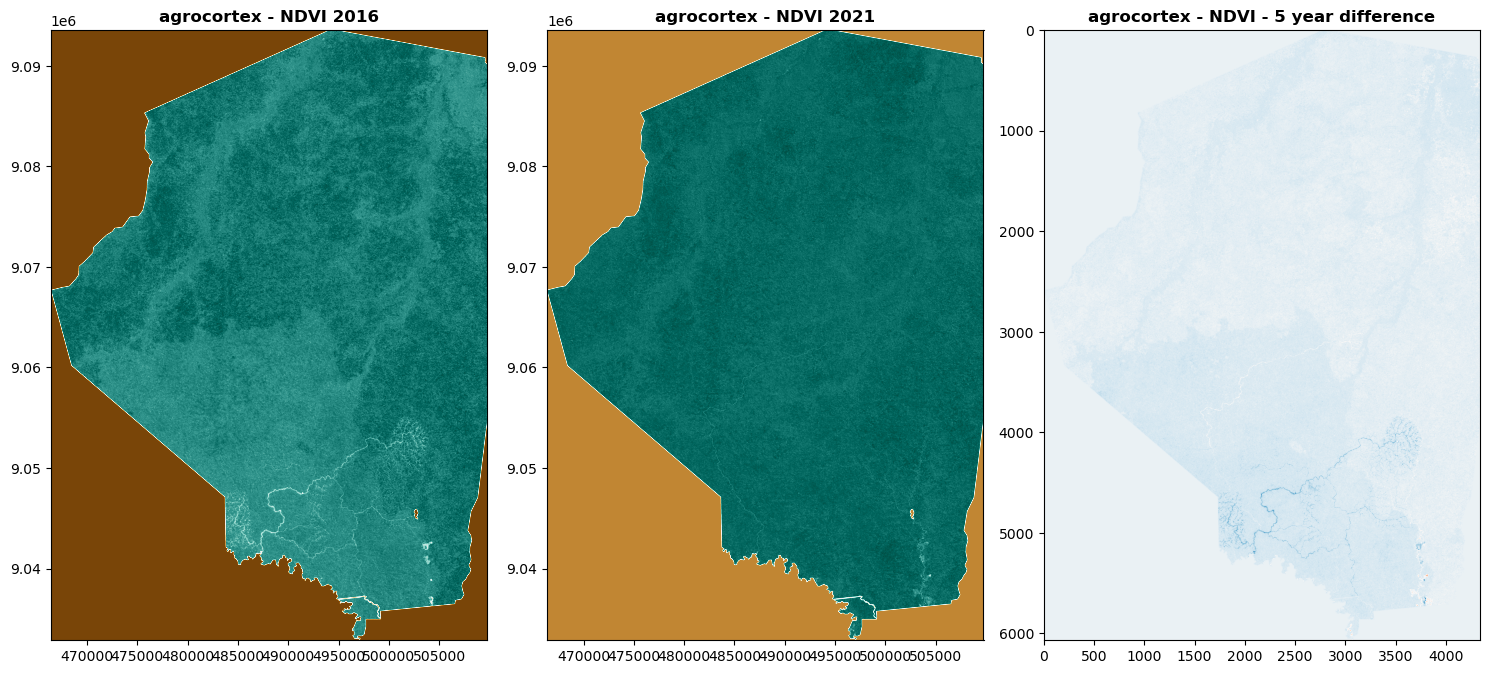

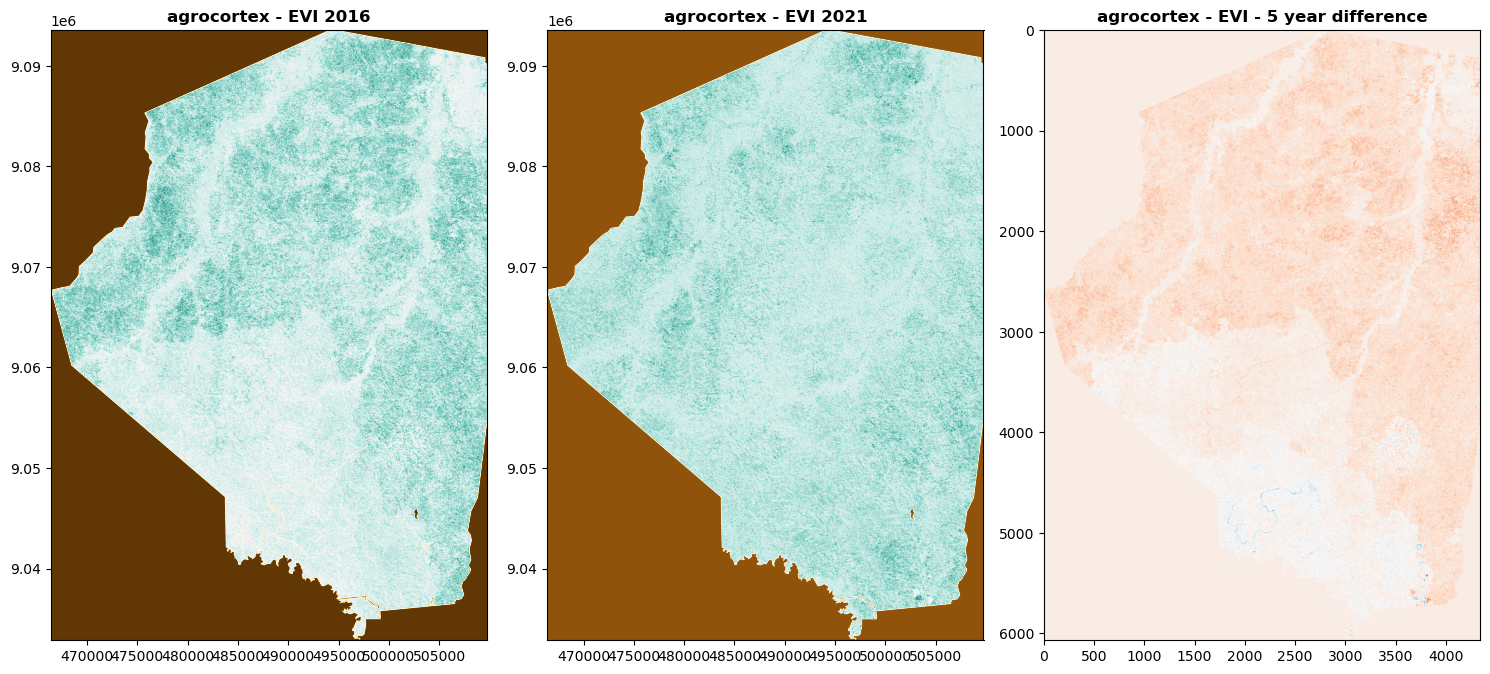

In [52]:
compute_indices(agro_bands_dict)

### 3.2 - Tumring REDD+ project

In [53]:
tumring_sent2_dir = 'layers/sent 2/camb'
tumring_sent2_layers = os.listdir(tumring_sent2_dir)
tumring_sent2_layers

['T48PWV_20160406T033242_B02.jp2',
 'T48PWV_20160406T033242_B04.jp2',
 'T48PWV_20160406T033242_B08.jp2',
 'T48PWV_20210331T031541_B02.jp2',
 'T48PWV_20210331T031541_B04.jp2',
 'T48PWV_20210331T031541_B08.jp2']

In [54]:
tumring_shapes_projected = boundaries(tumring_path_projected)

In [55]:
# The sentinel 2 bands for this area are projected using the epsg 32648, hence the boundaries with the same CRS are used
clip_area(tumring_shapes_projected, tumring_sent2_dir, tumring_sent2_layers)

In [56]:
turming_bands_dict = read_bands(tumring_sent2_layers)

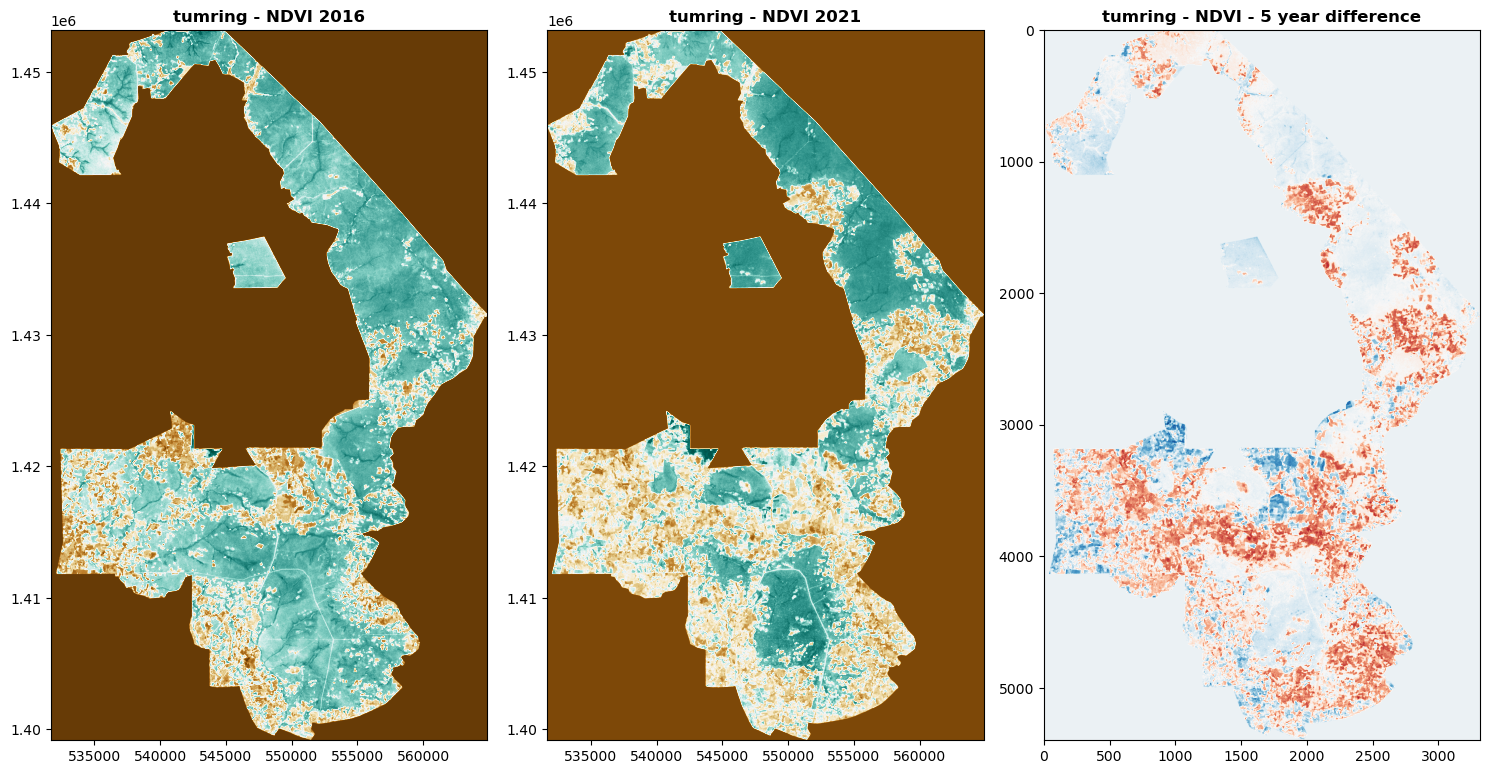

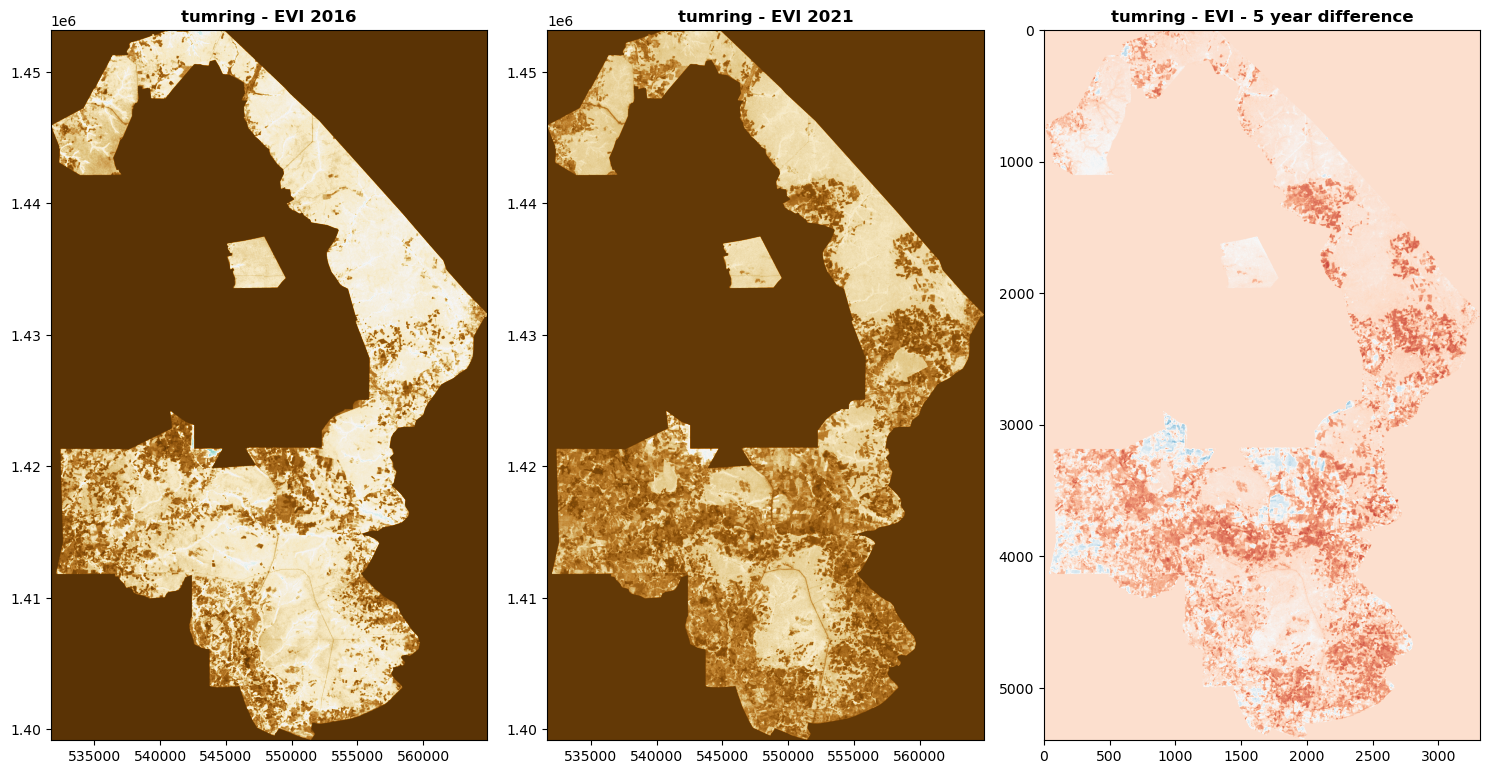

In [57]:
compute_indices(turming_bands_dict, 1)